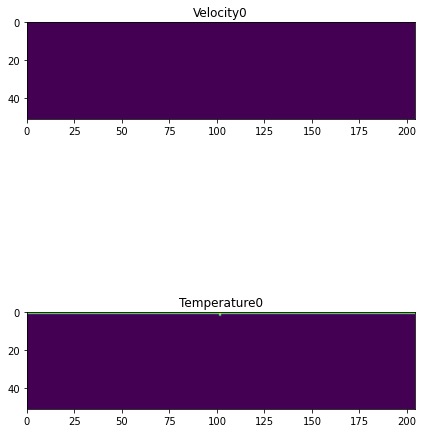

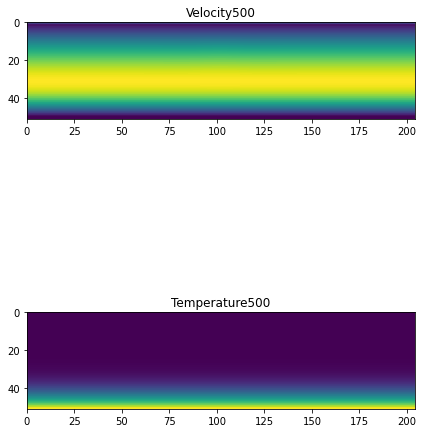

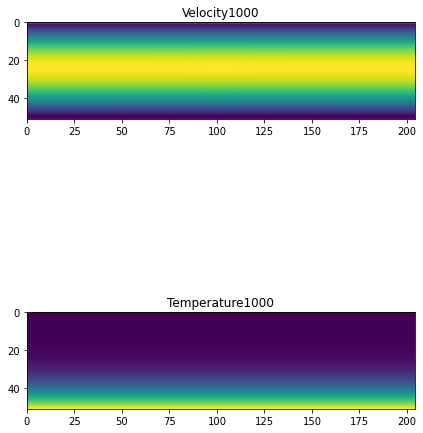

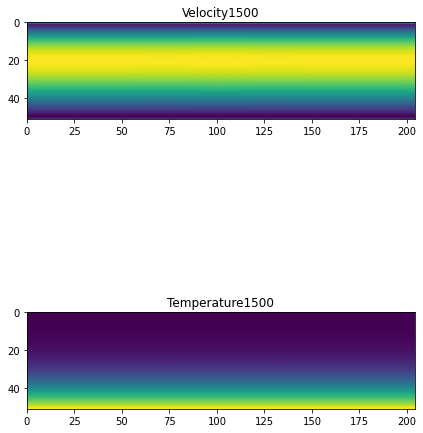

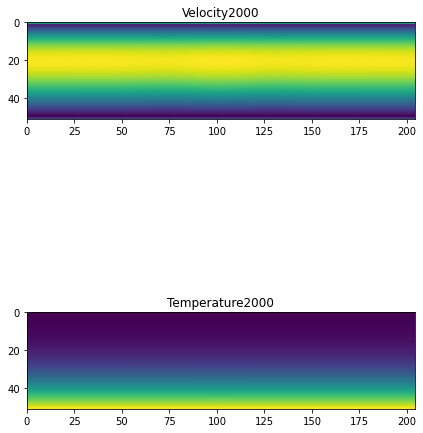

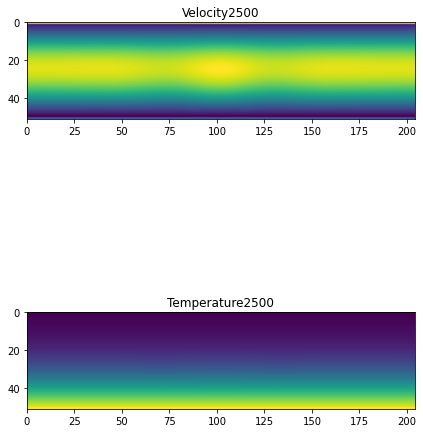

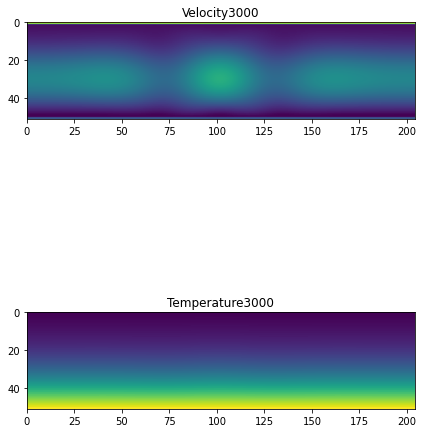

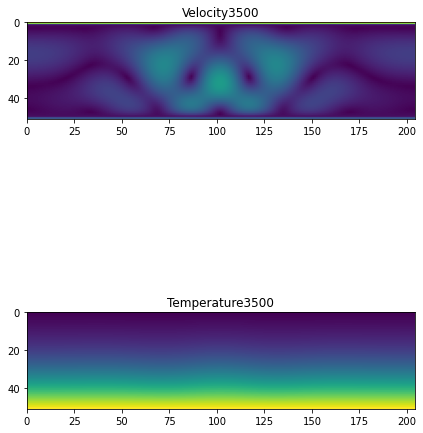

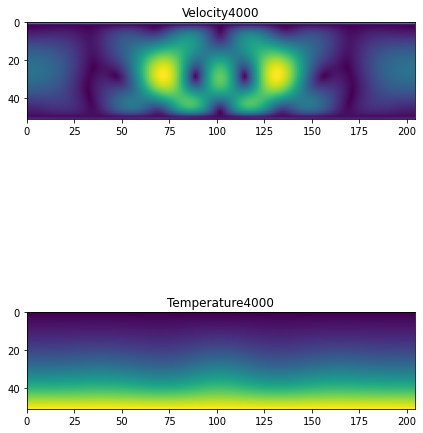

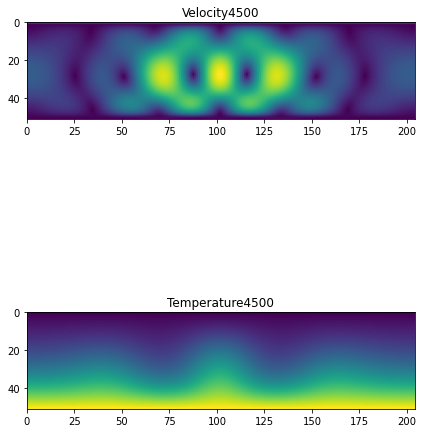

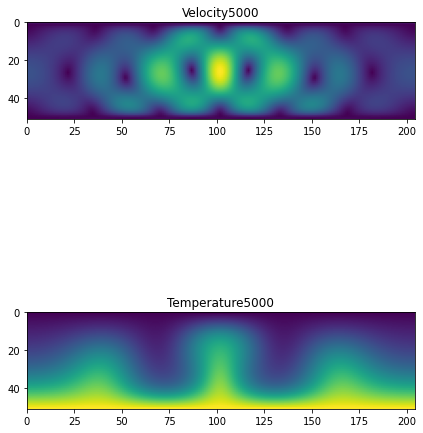

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import sys
sys.path.insert(1,'.')

from hdf5Helper import *

ly = 51
aspect_ratio = 4
lx = aspect_ratio*ly
delta_x = 1./(ly-2)
Pr = 1.
Ra = 20000
gr = 0.001
buoyancy = [0,gr]

Thot = 1
Tcold = 0
T0 = (Thot+Tcold)/2

delta_t = math.sqrt(gr*delta_x)
nu = math.sqrt(Pr/Ra)*delta_t/(delta_x*delta_x) # nu: kinematic viscosity in lattice units
k = math.sqrt(1./(Pr*Ra))*delta_t/(delta_x*delta_x) # k: thermal diffusivity
omegaNS = 1./(3*nu+0.5) # relaxation parameter for fluid
omegaT = 1./(3*k+0.5) # relaxation parameter for temperature

maxT = 5001
Vis_ts = 500
Vis_ind = 0

tNS = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
cxNS = np.array([0,1,0,-1,0,1,-1,-1,1])
cyNS = np.array([0,0,1,0,-1,1,1,-1,-1])
oppNS = np.array([0,3,4,1,2,7,8,5,6])

tT = np.array([1/3, 1/6, 1/6, 1/6, 1/6])
cxT = np.array([0,1,0,-1,0])
cyT = np.array([0,0,1,0,-1])
oppT = np.array([0,3,4,1,2])
x_space = np.arange(0,lx)
y_space = np.arange(0,ly)
xx,yy = np.meshgrid(x_space, y_space)

nnodes = lx*ly
gcoord = np.zeros((2,nnodes))
gcoord[0][:] = np.reshape(xx,nnodes)
gcoord[1][:] = np.reshape(yy,nnodes)

top_nodes = np.argwhere(gcoord[1][:]<0.5).flatten()
bottom_nodes = np.argwhere(gcoord[1][:]>(ly-1.5)).flatten()

fIn = np.ones((9,lx*ly))
for s in range(9):
    fIn[s][:] *= tNS[s]



tIn = np.ones((5,lx*ly))
for s in range(5):
    tIn[s][:] *= tT[s]*Tcold

#except bottom wall where T=1

for s in range(5):
    tIn[s][bottom_nodes] = tT[s]*Thot


for s in range(5):
    tIn[s][int((ly-2)*lx+(lx/2)-1)] = tT[s]*(1.1*Thot)
T = np.sum(tIn,axis=0)



# stream target matrices
stmNS = np.zeros((9,nnodes),dtype=np.int32)
indNS = np.arange(nnodes)
indNS = np.reshape(indNS, (ly, lx))
for i in range(9):
    tIndNS = np.roll(indNS, -cxNS[i],axis=1)
    tIndNS = np.roll(tIndNS, -cyNS[i],axis=0)
    tIndNS = np.reshape(tIndNS, (1,nnodes))
    stmNS[i][:] = tIndNS
    
stmT = np.zeros((5,nnodes),dtype=np.int32)
indT = np.arange(nnodes)
indT = np.reshape(indT,(ly,lx))
for i in range(5):
    tIndT = np.roll(indT, -cxT[i], axis=1)
    tIndT = np.roll(tIndT, -cyT[i], axis=0)
    tIndT = np.reshape(tIndT, (1,nnodes))
    stmT[i][:] = tIndT

# main loop
for cycle in range(maxT):
    # macroscopic variables
    rho = np.sum(fIn, axis=0)
    T = np.sum(tIn, axis=0)
    ux = np.dot(np.transpose(cxNS),fIn)/rho
    uy = np.dot(np.transpose(cyNS),fIn)/rho
    
    

    # collision step fluid
    fEq = np.zeros_like(fIn)
    force = np.zeros_like(fIn)
    fOut = np.zeros_like(fIn)
    
    for spd in range(9):
        cuNS = 3*(cxNS[spd]*ux + cyNS[spd]*uy)
        fEq[spd][:]=tNS[spd]*rho*(1.+cuNS + (0.5)*cuNS*cuNS - (3./2.)*(ux*ux + uy*uy))
        force[spd][:] = 3*tNS[spd]*rho*(T-T0)*(cxNS[spd]*buoyancy[0]+cyNS[spd]*buoyancy[1])/(Thot-Tcold)
        fOut[spd][:] = fIn[spd][:] - omegaNS*(fIn[spd][:]-fEq[spd][:]) + force[spd][:]
    
    # collision step temperature
    tEq = np.zeros_like(tIn)
    tOut = np.zeros_like(tIn)
    for i in range(5):
        cu = 3*(cxT[i]*ux + cyT[i]*uy)
        tEq[i][:] = T*tT[i]*(1+cu)
        tOut[i][:] = tIn[i][:] - omegaT*(tIn[i][:]-tEq[i][:])
    
    #microscopic boundary conditions for fluid
    for i in range(9):
        fOut[i][top_nodes] = fIn[oppNS[i],top_nodes]
        fOut[i][bottom_nodes] = fIn[oppNS[i],bottom_nodes]
        
        
        
        
    for i in range(9): # streaming fluid
        fIn[i][stmNS[i][:]] = fOut[i][:]
        
    for i in range(5): # stream temperature
        tIn[i][stmT[i][:]] = tOut[i][:]
    
        
        

    # microscopic boundary conditions for temperature
    for b in bottom_nodes:
        tIn[4,b] = Tcold-tIn[0][b]-tIn[1][b]-tIn[2][b]-tIn[3][b]
    for t in top_nodes:
        tIn[2,t] = Thot-tIn[0][t]-tIn[1][t]-tIn[3][t]-tIn[4][t]
        
    if cycle%Vis_ts==0:
        uMag = np.sqrt(ux*ux + uy*uy)
        fig,(ax1,ax2) = plt.subplots(nrows=2,figsize=(6,10))
        ax1.imshow(np.reshape(uMag,(ly,lx)),extent=[0,lx,0,ly])
        ax1.set_title('Velocity' + str(cycle))
        ax2.imshow(np.reshape(T,(ly,lx)),extent=[0,lx,0,ly])
        ax2.set_title('Temperature' + str(cycle))
        plt.tight_layout()
        ax1.invert_yaxis()
        ax2.invert_yaxis()
        plt.show()
        
        # write data to HDF5
        uz = np.zeros_like(ux)
        dims = (1,int(ly),int(lx))
        h5_file = 'out'+str(Vis_ind)+'.h5'
        xmf_file = 'data'+str(Vis_ind)+'.xmf'
        writeH5(T,ux,uy,uz,h5_file)
        writeXdmf(dims,delta_x,xmf_file,h5_file)
        Vis_ind+=1
        
